<a href="https://colab.research.google.com/github/ttogle918/NLU_3-/blob/main/%EC%9A%B0%EA%B2%BD%ED%99%94_sts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLU - 문장 유사도 계산 (STS)**

## **과제 목표**

- 두 개의 한국어 문장을 입력받아 두 문장의 의미적 유사도를 출력
- regression task (0 ≤ target ≤ 5)

## **학습 데이터셋(Dataset description)**

- [KLUE-STS](https://klue-benchmark.com/tasks/67/data/download)
  - AIRBNB (에어비앤비 리뷰)
  - policy (정책 뉴스)
  - paraKOQC (스마트홈 쿼리)

  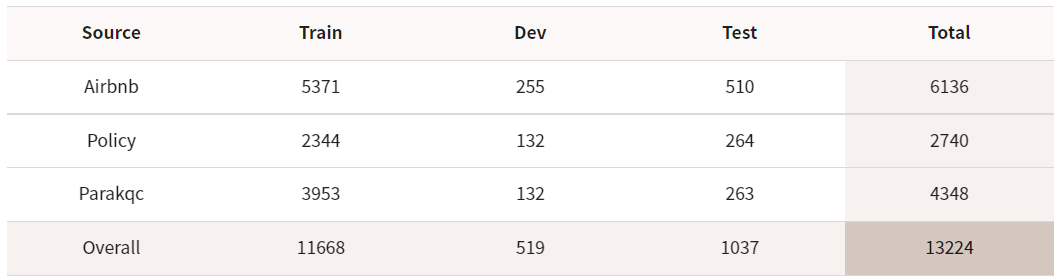

## **과제 결과물**
- 학습된 모델 (모델 자유 선택) (train set만 사용해 학습)
- 학습 방식 보고서
 - 어떤 모델을 선택했나
 - 어떻게 파라미터를 튜닝했나
 - 어떤 훈련 과정을 거쳤는가
- dev set score (F1)
- 문장 유사도를 출력하는 API (프레임워크 자유 선택)

## **설치 및 설정(Set up)**

In [ ]:
# Hugging Face의 트랜스포머 모델 설치
!pip install transformers
!pip install sentence_transformers datasets
!pip install datasets

In [ ]:
# 라이브러리
import os
import sys
import re
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import logging
import time
from datetime import datetime

import torch
import tensorflow as tf

from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

In [ ]:
# logger
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

## **데이터셋 불러오기(Load Dataset)**
- STS 데이터는 두 개의 문장 쌍과 이 두 문장 사이의 유사도 점수로 구성됨.
- STS데이터를 학습하여 문장과 문장간 서로 얼마나 유사한지를 예측.

In [ ]:
# KLUE-STS 데이터셋 다운로드
dataset = load_dataset('klue', 'sts')

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# 데이터셋 구조
dataset

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 11668
    })
    validation: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 519
    })
})

In [ ]:
# 데이터셋 중 train 첫째 줄 내용
dataset['train'][0]

{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [ ]:
# 데이터셋 중 validation 첫째 줄 내용
dataset['validation'][0]

{'guid': 'klue-sts-v1_dev_00000',
 'labels': {'binary-label': 1, 'label': 4.9, 'real-label': 4.857142857142857},
 'sentence1': '무엇보다도 호스트분들이 너무 친절하셨습니다.',
 'sentence2': '무엇보다도, 호스트들은 매우 친절했습니다.',
 'source': 'airbnb-rtt'}

## **데이터 전처리(Data Preprocessing)**
- 데이터 정제
 - 특수문자 제거
 - 한글, 영어, 숫자를 제외하고 모두 제거

In [ ]:
# dataset['train'] -> 데이터프레임(DataFrame)으로 보기
import pandas as pd

sentence1, sentence2, labels1 = [], [], []

for data1 in dataset['train'] :
  sentence1.append(data1['sentence1'])
  sentence2.append(data1['sentence2'])
  labels1.append(data1['labels']['real-label'])

train_data = pd.DataFrame({'sentence1' : sentence1, 'sentence2' : sentence2, 'labels' : labels1})
train_data.head(3)

,sentence1,sentence2,labels
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,3.714286
1,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,0.000000
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.333333


In [ ]:
# dataset['validation'] -> 데이터프레임(DataFrame)으로 보기
sentence3, sentence4, labels2 = [], [], []

for data2 in dataset['validation'] :
  sentence3.append(data2['sentence1'])
  sentence4.append(data2['sentence2'])
  labels2.append(data2['labels']['real-label'])

test_data = pd.DataFrame({'sentence1' : sentence3, 'sentence2' : sentence4, 'labels' : labels2})
test_data.head(3)

,sentence1,sentence2,labels
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.857143
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.428571
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.285714


In [ ]:
# 특수문자 제거
# 한글, 영어, 숫자를 제외하고 모두 제거
# def cleaning(sentence) :
#   return re.sub('一-龥㐀-䶵豈-龎[-=+#/:^$@"※~&%ㆍ』\‘〈〉|()[]<>`\'…》《]','', sentence)

In [ ]:
# klue_sts_train : 훈련용 / klue_sts_test : 테스트용
# test 데이터가 없어서 validation을 test로 사용
klue_sts_train = dataset['train']
klue_sts_test = dataset['validation']

- InputExample() 클래스를 통해, 두 개의 문장 쌍과 라벨을 묶어 모델이 학습할 수 있는 형태로 변환
- 배치학습을 위해 train 데이터를 DataLoader()로 묶음
- EmbeddingSimilarityEvaluator() 을 통해 모델 평가 시 사용할 test 검증기 만듦

In [ ]:
def make_sts_input_example(dataset):
    ''' 
    Transform to InputExample
    ''' 
    input_examples = []
    for i, data in enumerate(dataset):
        sentence1 = data['sentence1']
        sentence2 = data['sentence2']
        score = (data['labels']['label']) / 5.0  # normalize 0 to 5
        input_examples.append(InputExample(texts=[sentence1, sentence2], label=score))

    return input_examples

In [ ]:
sts_train_examples = make_sts_input_example(klue_sts_train)
sts_test_examples = make_sts_input_example(klue_sts_test)

In [ ]:
# Train Dataloader
train_dataloader = DataLoader(
    sts_train_examples,
    shuffle=True,
    batch_size=32,
)

# test 검증기
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_test_examples,
    name="sts-test",
)

## **EDA(Exploratory Data Analysis)**
- 데이터 분석(가설 검정??)
- 시각화

## **사전학습모델 불러오기(Load Pretrained Model)**
- 임베딩모델 불러오기
- Mean Pooling(평균 풀링) 사용

- [SBERT-only-STS-training](https://colab.research.google.com/drive/1CJqg1LdNU0eMvcWYjBAE4RtDKysPKBae?usp=sharing#scrollTo=0-NWkVzvHxoe)

In [ ]:
# model : klue/roberta-base 사용
pretrained_model_name = 'klue/roberta-base'

In [ ]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path=pretrained_model_name,  # klue/roberta-base 사용
    max_seq_length=256,
    do_lower_case=True
)

# Mean Pooling(평균 풀링)만 사용. -> 문장의 모든 토큰 임베딩 벡터를 풀링함.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

2022-05-26 15:03:09 - Use pytorch device: cuda




---



## **모델 훈련(Model Training)**


###**Model : klue/roberta-base**
batch_size : 16

In [ ]:
# epochs = 4, batch_size = 16
sts_num_epochs = 4
train_batch_size = 16
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-26 15:03:09 - Warmup-steps: 292


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-26 15:15:34 - Save model to output/training_sts-klue-roberta-base-2022-05-26_15-03-09


## **모델 평가(Model Evaluation)**

In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-26 15:15:36 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-26 15:15:37 - Cosine-Similarity :	Pearson: 0.8856	Spearman: 0.8861
2022-05-26 15:15:37 - Manhattan-Distance:	Pearson: 0.8860	Spearman: 0.8817
2022-05-26 15:15:37 - Euclidean-Distance:	Pearson: 0.8866	Spearman: 0.8823
2022-05-26 15:15:37 - Dot-Product-Similarity:	Pearson: 0.8754	Spearman: 0.8724


0.8861225614244054



---


###**Model : klue/roberta-base**
batch_size : 32

In [ ]:
# epochs = 4, batch_size = 32
sts_num_epochs = 4
train_batch_size = 32
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-26 15:15:37 - Warmup-steps: 146


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-26 15:27:49 - Save model to output/training_sts-klue-roberta-base-2022-05-26_15-15-37


In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-26 15:27:51 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-26 15:27:52 - Cosine-Similarity :	Pearson: 0.8897	Spearman: 0.8898
2022-05-26 15:27:52 - Manhattan-Distance:	Pearson: 0.8865	Spearman: 0.8843
2022-05-26 15:27:52 - Euclidean-Distance:	Pearson: 0.8874	Spearman: 0.8848
2022-05-26 15:27:52 - Dot-Product-Similarity:	Pearson: 0.8766	Spearman: 0.8741


0.8897905164663048


---


###**Model : klue/roberta-base**
batch_size : 64

In [ ]:
# epochs = 4, batch_size = 64
sts_num_epochs = 4
train_batch_size = 64
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-26 15:27:52 - Warmup-steps: 73


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-26 15:40:05 - Save model to output/training_sts-klue-roberta-base-2022-05-26_15-27-52


In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-26 15:40:06 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-26 15:40:08 - Cosine-Similarity :	Pearson: 0.8927	Spearman: 0.8943
2022-05-26 15:40:08 - Manhattan-Distance:	Pearson: 0.8897	Spearman: 0.8875
2022-05-26 15:40:08 - Euclidean-Distance:	Pearson: 0.8897	Spearman: 0.8878
2022-05-26 15:40:08 - Dot-Product-Similarity:	Pearson: 0.8742	Spearman: 0.8728


0.8942894654072163


---


###**Model : klue/roberta-base**
batch_size : 128

In [ ]:
# epochs = 4, batch_size = 128
sts_num_epochs = 4
train_batch_size = 128
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-26 15:40:08 - Warmup-steps: 37


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-26 15:52:18 - Save model to output/training_sts-klue-roberta-base-2022-05-26_15-40-08


In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-26 15:52:19 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-26 15:52:21 - Cosine-Similarity :	Pearson: 0.8908	Spearman: 0.8928
2022-05-26 15:52:21 - Manhattan-Distance:	Pearson: 0.8862	Spearman: 0.8844
2022-05-26 15:52:21 - Euclidean-Distance:	Pearson: 0.8868	Spearman: 0.8850
2022-05-26 15:52:21 - Dot-Product-Similarity:	Pearson: 0.8691	Spearman: 0.8693


0.8928077309092207

▶Model **`klue/roberta-base`**는 batch_size = 64 일 때 가장 성능이 좋음.